<a href="https://colab.research.google.com/github/guyyariv/DL_ex3/blob/master/main10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import copy
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import imageio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating data sets

In [3]:
batch_size = 64
latent_dim = 20
train_size_for_mlp = 0.0033

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.MNIST(
    root='../input', train=True, download=True, transform=transform
)

trainset_mlp, trainset_autoencoder = torch.utils.data.random_split(trainset, [2, 60000-2])

train_loader_mlp = DataLoader(
    trainset_mlp, batch_size=batch_size, shuffle=True
)

train_loader_autoencoder = DataLoader(
    trainset_autoencoder, batch_size=batch_size, shuffle=True
)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.MNIST(
    root='../input', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)


def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)

    return torch.sum(y_true == y_pred) / len(y_true)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/MNIST/raw/train-images-idx3-ubyte.gz to ../input/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/MNIST/raw



# Autoencoder architecture

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024, 256)
        self.fc = nn.Linear(256, latent_dim)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x).reshape((x.shape[0], 1024))  # compressed representation
        x = F.relu(self.fc1(x))
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.fc = nn.Linear(latent_dim, 256)
        self.fc1 = nn.Linear(256, 1024)
        self.t_conv1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        ## decode ##
        x = F.relu(self.fc(x))
        x = F.relu(self.fc1(x)).reshape((x.shape[0], 16, 8, 8))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train Autoencoder

In [ ]:
def train_autoencoder(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_autoencoder, train_loader=train_loader_autoencoder):
    model.train()
    loss_list = []
    torch.manual_seed(42)
    criterion = nn.BCELoss()  # binary cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    outputs = []
    for epoch in range(num_epochs):
        loss_counter = 0.0
        counter = 0
        for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_counter += loss.item()
            counter += 1
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        loss_list.append(loss_counter / counter)
        outputs.append((i, img, recon),)
    plt.plot(loss_list)
    plt.legend('loss', 'epochs')
    plt.show()
    torch.save(model.encoder.state_dict(), f'encoder_model_{latent_dim}.pth')
    torch.save(model.decoder.state_dict(), f'decoder_model_{latent_dim}.pth')

    return outputs

model = ConvAutoencoder()
max_epochs = 50
outputs = train_autoencoder(model, num_epochs=max_epochs)

for k in range(0, max_epochs):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap='gray')

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0], cmap='gray')

plt.show()


# Decorrelation

In [ ]:
latents = [5, 8, 10, 14, 20]
result = dict()
for latent_ in latents:
    latent_dim=latent_
    encoder = Encoder()
    
    encoder.load_state_dict(copy.deepcopy(torch.load(f"encoder_model_{latent_}.pth", device)))
    trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
    for i, data in enumerate(trainloader):
        images, _ = data
        latent = encoder(images)
        if i == 0:
          break
    corr = torch.corrcoef(latent.T).detach().numpy()
    result[latent_] = np.linalg.norm(corr)
    print(result.keys())
    print(result.values())

dict_keys([5])
dict_values([2.4326987])
dict_keys([5, 8])
dict_values([2.4326987, 3.3967464])
dict_keys([5, 8, 10])
dict_values([2.4326987, 3.3967464, 3.9710805])
dict_keys([5, 8, 10, 14])
dict_values([2.4326987, 3.3967464, 3.9710805, 4.9198337])


# MLP Architecture

In [ ]:
class Mlp(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Mlp, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim * 2)
        self.linear2 = nn.Linear(input_dim * 2, input_dim)
        self.linear3 = nn.Linear(input_dim, input_dim)
        self.linear4 = nn.Linear(input_dim, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        return x        


# MLP + Encoder Architecture

In [ ]:
class MLPEncoder(nn.Module):

    def __init__(self):
        super(MLPEncoder, self).__init__()
        self.encoder = Encoder()
        self.mlp = Mlp()

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp(x)
        return x

# Train MLP + Encoder

In [ ]:
def train_classifier(model, train_loader, trainset, encoder, criterion, optimizer):
    model.train()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=int(len(trainset)/train_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def eval_classifier(model, test_loader, testset, encoder, criterion):
    model.eval()
    loss_counter = 0.0
    acc_counter = 0.0
    counter = 0
    for i, data in tqdm(enumerate(test_loader), total=int(len(testset) / test_loader.batch_size)):
        img, labels = data
        if encoder:
            img = encoder(img)
        predict = model(img)
        loss = criterion(predict, labels)
        loss_counter += loss.item()
        acc_counter += calculate_accuracy(labels, predict).item()
        counter += 1
    return loss_counter, acc_counter, counter


def classifier(model, num_epochs=10, learning_rate=1e-3, trainset=trainset_mlp, train_loader=train_loader_mlp, model_name='Mlp'):
    loss_list = []
    acc_list = []
    loss_list_test = []
    acc_list_test = []
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()  # cross entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    encoder = None
    if model_name == 'Mlp':
        encoder = Encoder()
        encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model.pth", device)))
    for epoch in range(num_epochs):
        loss_counter, acc_counter, counter = train_classifier(model, train_loader, trainset, encoder, criterion, optimizer)
        loss_counter_test, acc_counter_test, counter_test = eval_classifier(model, testloader, testset, encoder, criterion)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss_counter / counter))
        print('Epoch:{}, acc:{:.4f}'.format(epoch+1, acc_counter / counter))
        print('Epoch:{}, Loss test:{:.4f}'.format(epoch+1, loss_counter_test / counter_test))
        print('Epoch:{}, acc test:{:.4f}'.format(epoch+1, acc_counter_test / counter_test))
        loss_list.append(loss_counter / counter)
        acc_list.append(100 * acc_counter / counter)
        loss_list_test.append(loss_counter_test / counter_test)
        acc_list_test.append(100 * acc_counter_test / counter_test)
    plt.plot(loss_list)
    plt.plot(loss_list_test)
    plt.title('loss')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(acc_list)
    plt.plot(acc_list_test)
    plt.title('accuracy')
    plt.legend(['train', 'test'])
    plt.show()


model = Mlp()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.02, model_name='Mlp')

model = MLPEncoder()
max_epochs = 20
outputs = classifier(model, num_epochs=max_epochs, learning_rate=0.01, model_name='MLPEncoder')


# GAN Architecture

In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(input_dim, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(512, input_dim)
        self.linear5 = nn.Linear(input_dim, input_dim * 2)
        self.linear6 = nn.Linear(256, latent_dim)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.batch_norm_1(self.linear2(x)))
        x = self.relu(self.batch_norm_2(self.linear3(x)))
        x = self.linear6(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(latent_dim, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear6 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.sigmoid(self.linear6(x))
        return x

# Train GAN

In [11]:
def generate_latent(number_of_images=batch_size, latent_dimension=latent_dim):
    """ Generate noise for number_of_images images, with a specific noise_dimension """
    return torch.randn(number_of_images, latent_dimension)


def generate_specific_digit(number_of_images=batch_size, digit_to_generate=0):
    zeros = torch.zeros(number_of_images)
    zeros[:] = digit_to_generate
    return zeros.to(torch.int64)


def initialize_optimizers(generator, discriminator, lr_genrator, lr_discriminator):
    """ Initialize optimizers for Generator and Discriminator. """
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_genrator, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))
    return generator_optimizer, discriminator_optimizer

In [ ]:
batch_size=128


def train_epoch(generator, discriminator, encoder, loss_function, generator_optimizer, discriminator_optimizer):
    real_label, fake_label = 1.0, 0.0
    loss_dis = 0.0
    loss_gen = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        # train discriminator
        discriminator.zero_grad()
        img, _ = data
        real_images = encoder(img)
        label = torch.full((img.shape[0],1), real_label)
        output = discriminator(real_images)
        error_real_images = loss_function(output, label)
        error_real_images.backward()
        D_x = output.mean().item()

        latent = generate_latent(img.shape[0])
        fake = generator(latent)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        error_fake_images = loss_function(output, label)
        error_fake_images.backward()
        D_G_z1 = output.mean().item()
        errD = error_real_images + error_fake_images
        discriminator_optimizer.step()

        # train generator
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        loss_dis += errD
        loss_gen += errG
        counter += 1
    return loss_dis / counter, loss_gen / counter


def train(generator, discriminator, num_epochs=30, lr_discriminator=1e-3, lr_generator=1e-3, trainset=trainset, train_loader=trainloader):
    loss_discriminator = []
    loss_generator = []
    torch.manual_seed(42)
    encoder = Encoder()
    encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model_20.pth", device)))
    criterion = nn.BCELoss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator, lr_generator, lr_discriminator)
    for epoch in range(num_epochs):
        loss_dis, loss_gen = train_epoch(generator, discriminator, encoder, criterion, generator_optimizer, discriminator_optimizer)
        print('Epoch:{}, Loss discriminator:{:.4f}'.format(epoch+1, loss_dis))
        print('Epoch:{}, Loss generator:{:.4f}'.format(epoch+1, loss_gen))
        loss_discriminator.append(loss_dis)
        loss_generator.append(loss_gen)
        generate_images(generator)
        plt.plot(loss_discriminator)
        plt.plot(loss_generator)
        plt.title('GAN loss')
        plt.legend(['discriminator', 'generator'])
        plt.show()
        torch.save(generator.state_dict(), f'generator_{latent_dim}_5.pth')
    print(loss_discriminator, loss_generator)
    plt.plot(loss_discriminator)
    plt.plot(loss_generator)
    plt.title('GAN loss')
    plt.legend(['discriminator', 'generator'])
    plt.show()
    torch.save(generator.state_dict(), 'generator_1.pth')
    


generator = Generator()
discriminator = Discriminator()
num_epochs = 120
train(generator, discriminator, num_epochs, lr_discriminator=0.0002, lr_generator=0.0002)

In [107]:
def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_20.pth", device)))

    latents = generate_latent()
    generate_images = generator(latents)
    # print("Generate images: ", generate_images)
    print(generate_images[0].shape)
    outputs = decoder(generate_images[:2])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()
    return latents[0], latents[1]

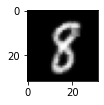

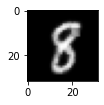

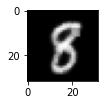

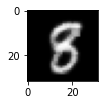

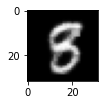

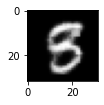

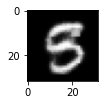

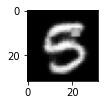

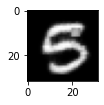

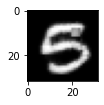

In [30]:
generator = Generator()
generator.load_state_dict(copy.deepcopy(torch.load("generator_20_5.pth", device)))
latents = generate_latent()
l1 = latents[0]
l2 = latents[1]
decoder = Decoder()
decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_20.pth", device)))

for a in range(10):
    a = a / 10
    # interpolation = (a*l1 + (1-a)*l2).reshape((1, 20))
    generator.eval()
    genetared = generator(latents[:2])
    interpolation = a*genetared[0] + (1-a)*genetared[1]
    outputs = decoder(interpolation.reshape((1, 20)))
    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()

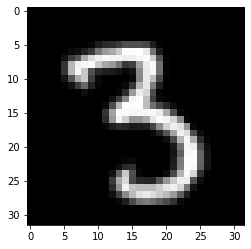

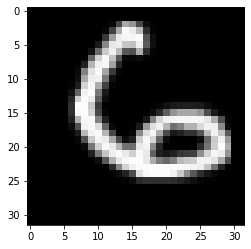

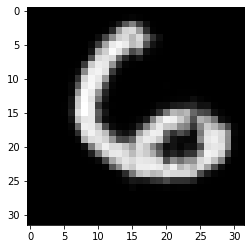

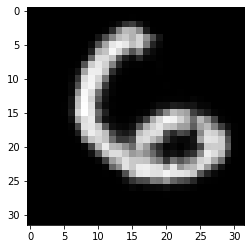

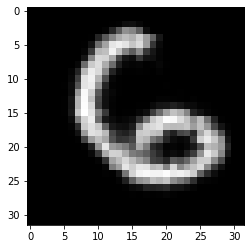

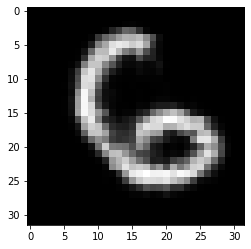

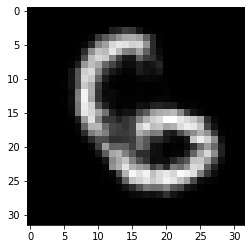

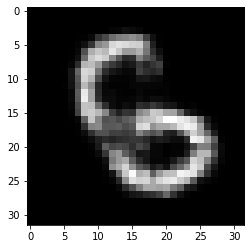

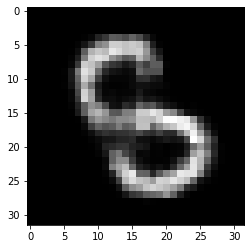

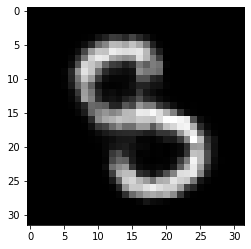

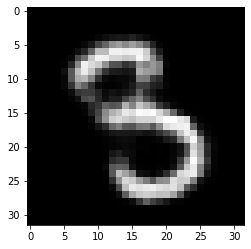

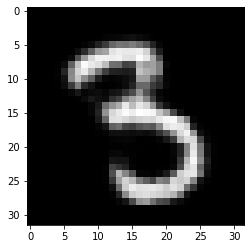

In [7]:
encoder = Encoder()
encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model_20.pth", device)))
encoder.eval()
decoder = Decoder()
decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_20.pth", device)))
decoder.eval()

for i, data in enumerate(train_loader_mlp):
    img, labels = data
    l1 = img[0]
    plt.imshow(l1.reshape((32, 32)), cmap='gray')
    plt.show()
    l2 = img[1]
    plt.imshow(l2.reshape((32, 32)), cmap='gray')
    plt.show()
    for a in range(10):
        a = a / 10
        # interpolation = (l1 + (1-a)*l2).reshape((1, 1, 32, 32))
        interpolation = a*encoder(l1.reshape(1, 1, 32, 32)) + (1-a)*encoder(l2.reshape(1, 1, 32, 32))
        interpolation = decoder(interpolation)
        plt.imshow(interpolation.detach().numpy().reshape((32, 32)), cmap='gray')
        plt.show()

# Conditional GAN

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, input_dim=latent_dim):
        super(ConditionalGenerator, self).__init__()
        self.linear1 = nn.Linear(input_dim+10, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear6 = nn.Linear(256, latent_dim)
        self.embedding = nn.Embedding(10, 10)
        self.relu = nn.ReLU()

    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear6(x)
        return x


class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.linear1 = nn.Linear(latent_dim+10, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear6 = nn.Linear(256, 1)
        self.embedding = nn.Embedding(10, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, labels):
        c = self.embedding(labels)
        x = torch.cat([x, c], 1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.sigmoid(self.linear6(x))
        return x

# Train

In [ ]:
batch_size=100


def generate_fake_labels(number_of_images=batch_size):
    return torch.randint(0, 10, (number_of_images,))


def train_epoch(generator, discriminator, encoder, loss_function, generator_optimizer, discriminator_optimizer):
    real_label, fake_label = 1.0, 0.0
    loss_dis = 0.0
    loss_gen = 0.0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        # train discriminator
        discriminator.zero_grad()
        img, digit_labels = data
        real_images = encoder(img)
        label = torch.full((img.shape[0],1), real_label)
        output = discriminator(real_images, digit_labels)
        error_real_images = loss_function(output, label)
        error_real_images.backward()
        D_x = output.mean().item()

        latent = generate_latent(img.shape[0])
        fake_digit_label = generate_fake_labels(img.shape[0])
        fake = generator(latent, fake_digit_label)
        output = discriminator(fake.detach(), fake_digit_label)
        label.fill_(fake_label)
        error_fake_images = loss_function(output, label)
        error_fake_images.backward()
        D_G_z1 = output.mean().item()
        errD = error_real_images + error_fake_images
        discriminator_optimizer.step()

        # train generator
        generator.zero_grad()
        generated_data = generator(latent, fake_digit_label)
        output = discriminator(generated_data, fake_digit_label)
        label.fill_(real_label)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        loss_dis += errD
        loss_gen += errG
        counter += 1
    return loss_dis / counter, loss_gen / counter


def train(generator, discriminator, num_epochs=30, lr_discriminator=1e-3, lr_generator=1e-3, trainset=trainset, train_loader=trainloader):
    loss_discriminator = []
    loss_generator = []
    torch.manual_seed(42)
    encoder = Encoder()
    encoder.load_state_dict(copy.deepcopy(torch.load("encoder_model_20.pth", device)))
    criterion = nn.BCELoss()
    generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator, lr_generator, lr_discriminator)
    for epoch in range(num_epochs):
        loss_dis, loss_gen = train_epoch(generator, discriminator, encoder, criterion, generator_optimizer, discriminator_optimizer)
        print('Epoch:{}, Loss discriminator:{:.4f}'.format(epoch+1, loss_dis))
        print('Epoch:{}, Loss generator:{:.4f}'.format(epoch+1, loss_gen))
        loss_discriminator.append(loss_dis)
        loss_generator.append(loss_gen)
        generate_images(generator)

        plt.plot(loss_discriminator)
        plt.plot(loss_generator)
        plt.title('Conditional GAN loss')
        plt.legend(['discriminator', 'generator'])
        plt.show()
        torch.save(generator.state_dict(), 'cond_generator.pth')
    print(loss_discriminator, loss_generator)
    plt.plot(loss_discriminator)
    plt.plot(loss_generator)
    plt.title('Conditional GAN loss')
    plt.legend(['discriminator', 'generator'])
    plt.show()
    
    


generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_20.pth", device)))

    labels = generate_specific_digit(digit_to_generate=2)
    latents = generate_latent()
    generate_images = generator(latents, labels)
    # print("Generate images: ", generate_images)
    outputs = decoder(generate_images[:16])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()


num_epochs = 120
train(generator, discriminator, num_epochs, lr_discriminator=0.0002, lr_generator=0.00015)

In [14]:
def generate_images(generator):
    decoder = Decoder()
    decoder.load_state_dict(copy.deepcopy(torch.load("decoder_model_14.pth", device)))

    labels = generate_specific_digit(digit_to_generate=9)
    latents = generate_latent()
    generate_images = generator(latents, labels)
    # print("Generate images: ", generate_images)
    outputs = decoder(generate_images[:16])

    plt.figure(figsize=(4, 4))
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    recon = outputs.detach().numpy()
    for i, item in enumerate(recon):
        if i >= 16: break
        plt.subplot(4, 4, 0+i+1)
        plt.imshow(item[0], cmap='gray')

    plt.show()

generator = ConditionalGenerator()
generator.load_state_dict(copy.deepcopy(torch.load("cond_generator.pth", device)))
generate_images(generator)

TypeError: ignored